In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
import csv
import itertools as it
import pandas as pd
import researchpy as rp
import scipy
import seaborn as sns
sns.set()

DATAFILE="./data/acl-parscit.csv"

In [2]:
VENUES = {
    'D': 'EMNLP',
    'E': 'EACL',
    'J': 'CL',
    'N': 'NAACL',
    'K': 'CoNLL',
    'P': 'ACL',
    'Q': 'TACL',
}

def parse_csv_to_pandas(filename):
    '''
    A custom CSV parsing function to process the data in the Marcel format
    '''
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        df = defaultdict(list)
        
        for row in reader:
            paper_id = row[0]
            paper_venue = paper_id[0]
            year = int(row[1])
            citations = row[2].split(',')
            if len(citations) <= 1:
                # Front matter or articles that otherwise failed to parse any citations
                continue
            citations = [int(x) for x in citations]
            ages = [year - x for x in citations if x <= year]

            for a in ages:
                df['paper_id'].append(paper_id)
                df['venue'].append(VENUES.get(paper_venue, paper_venue))
                df['year'].append(year)
                df['cited_age'].append(a)
        
    return pd.DataFrame.from_dict(df)

# ACL Dataset — basic stats

We're using a dataset that only contains long and short papers from the main conferences and journals.

In [3]:
df = parse_csv_to_pandas(DATAFILE)

For the record, these are the exact ACL ID prefixes contained in this dataset:

In [4]:
df['paper_id'].apply(lambda x: x[:5]).unique()

array(['D10-1', 'D11-1', 'D12-1', 'D13-1', 'D14-1', 'D15-1', 'D16-1',
       'D17-1', 'D18-1', 'D19-1', 'E12-1', 'E14-1', 'E14-4', 'E17-1',
       'E17-2', 'J10-1', 'J10-2', 'J10-3', 'J10-4', 'J11-1', 'J11-2',
       'J11-3', 'J11-4', 'J12-1', 'J12-2', 'J12-3', 'J12-4', 'J13-1',
       'J13-2', 'J13-3', 'J13-4', 'J14-1', 'J14-2', 'J14-3', 'J14-4',
       'J15-1', 'J15-2', 'J15-3', 'J15-4', 'J16-1', 'J16-2', 'J16-3',
       'J16-4', 'J17-1', 'J17-2', 'J17-3', 'J17-4', 'J18-1', 'J18-2',
       'J18-3', 'J18-4', 'J19-1', 'N10-1', 'N12-1', 'N13-1', 'N15-1',
       'N16-1', 'N18-1', 'N18-2', 'N19-1', 'P10-1', 'P10-2', 'P11-1',
       'P11-2', 'P12-1', 'P12-2', 'P13-1', 'P13-2', 'P14-1', 'P14-2',
       'P15-1', 'P15-2', 'P16-1', 'P16-2', 'P17-1', 'P17-2', 'P18-1',
       'P18-2', 'P19-1', 'Q13-1', 'Q14-1', 'Q15-1', 'Q16-1', 'Q17-1',
       'Q18-1', 'Q19-1'], dtype=object)

Let's plot the **number of papers per year** in our dataset, as well as the **venues** they're coming from:

<IPython.core.display.Javascript object>


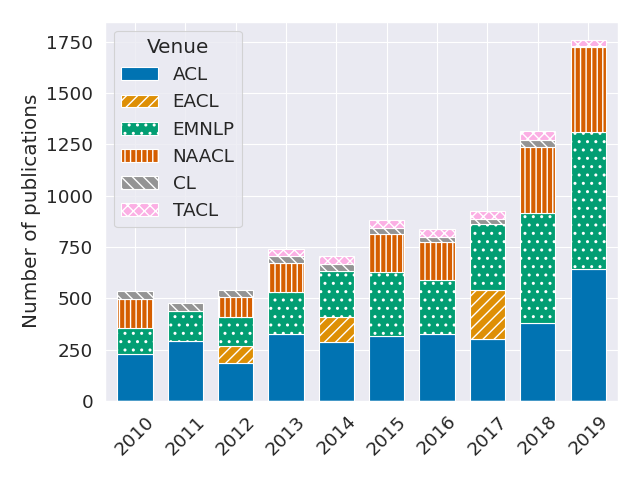

In [8]:
VENUE_PALETTE=sns.color_palette("colorblind")[:4] + sns.color_palette("colorblind")[7:5:-1]

sns.set_context("paper", font_scale=1.5)
pivot = df.groupby(['year', 'venue'])['paper_id'].nunique().reset_index().pivot(index='year', columns='venue', values='paper_id')
ax = pivot.loc[:,["ACL","EACL","EMNLP","NAACL","CL","TACL"]].plot.bar(
    stacked=True,
    rot=45,
    color=VENUE_PALETTE,
    width=0.7
)
ax.set_xlabel("")
ax.set_ylabel("Number of publications")
ax.get_legend().set_title("Venue")

if True:
    hatches = ["///", "..", "\\\\\\", "|||", "", "xxx"]
    hatches = ["", "///", "..", "|||", "\\\\\\", "xxx"]

    #('-', '+', 'x', '\\', '*', 'o', 'O', '.')
    
    for i, hatch in enumerate(hatches):
        for j in range(i * 10, (i * 10) + 10):
            ax.patches[j].set_hatch(hatch)

    for box, hatch in zip(ax.get_legend().get_patches(), hatches):
        box.set_hatch(hatch)

plt.tight_layout()
        
if True:
    plt.savefig('years.pgf', bbox_inches='tight')
    plt.savefig('years.pdf', bbox_inches='tight')



Before we look at the actual citations, let's **filter out**

- citations from the future, and
- citations older than 50 years.

In [9]:
df = df[df['cited_age'] >= 0]
df = df[df['cited_age'] <= 50]

Plot the distribution of citation age by year:

<IPython.core.display.Javascript object>


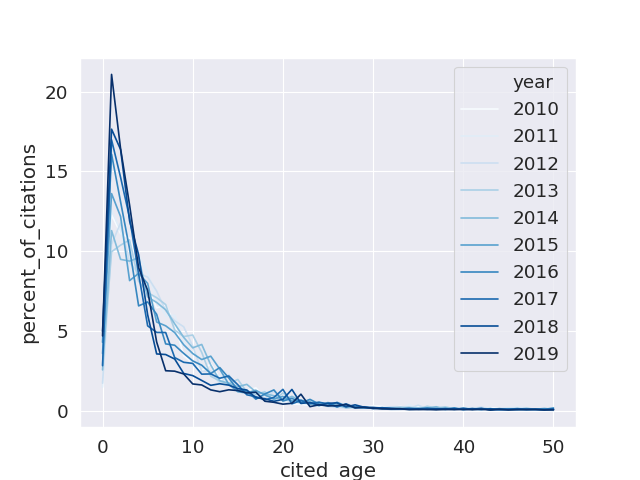

In [10]:
# Count citations by year & cited_age
counts = df.groupby(['year', 'cited_age']).count()
counts = counts.reset_index().filter(items=['year', 'cited_age', 'venue'])
counts.columns.values[-1] = "count"

# Normalize by total no. of citations in year
nfactor = df.groupby(['year']).count().reset_index()
counts['count'] = counts['count'].astype(float)
counts['percent_of_citations'] = counts.apply(lambda x: 100 * x[2] / float(nfactor[nfactor['year']==x[0]]['paper_id']), axis=1)

sns.lineplot(data=counts, x='cited_age', y='percent_of_citations', hue='year', legend='full', palette='Blues')

The plot above shows the **percentage of citations** that have a given age.

## Q1 (Recency): Is there a tendency for newer papers to cite more recently published papers?

We want to look at the age of citations by year.  Let's see a box plot of this distribution, which shows the quantiles of the age data:

<IPython.core.display.Javascript object>


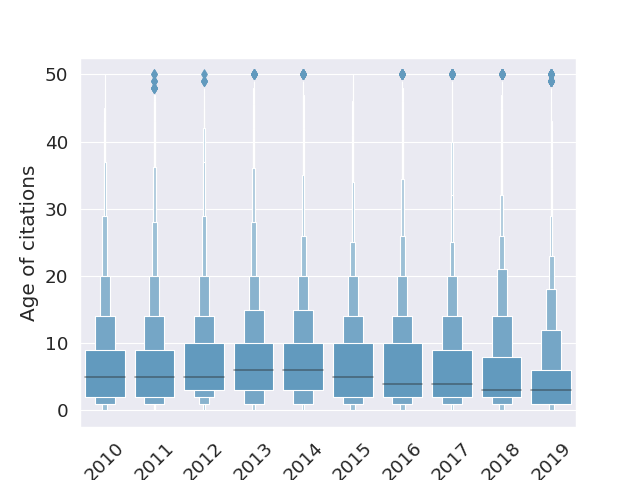

In [11]:
sns.set_context("paper", font_scale=1.5)
ax = sns.boxenplot(data=df, x='year', y='cited_age', palette=[sns.color_palette("Blues")[3]])

ax.set_xlabel("")
ax.set_ylabel("Age of citations")
plt.xticks(rotation=45)

if True:
    plt.savefig('recency.pgf', bbox_inches='tight')


Let's see some numerical stats about the citation age:

In [12]:
rp.summary_cont(df['cited_age'].groupby(df['year']))

,N,Mean,SD,SE,95% Conf.,Interval
year,,,,,,
2010,12919,7.272002,7.694207,0.067694,7.139317,7.404688
2011,12662,7.379087,7.613379,0.067659,7.246470,7.511704
2012,14679,7.631242,7.633068,0.063001,7.507755,7.754729
2013,21363,7.691008,7.625360,0.052171,7.588750,7.793265
2014,21208,7.664230,7.478259,0.051351,7.563580,7.764881
2015,25616,7.211235,7.407500,0.046282,7.120520,7.301950
2016,26465,7.000302,7.638855,0.046956,6.908267,7.092338
2017,30511,6.691718,7.424163,0.042503,6.608411,6.775025
2018,42962,6.259927,7.504589,0.036206,6.188962,6.330893


There is a downwards trend in the mean from 2013 onwards; however, the means in 2011/2012 were also lower than in 2013.  The downwards trend continues quite notably in 2019!

In [13]:
df['cited_age'].groupby(df['year']).median()

year
2010    5
2011    5
2012    5
2013    6
2014    6
2015    5
2016    4
2017    4
2018    3
2019    3
Name: cited_age, dtype: int64

### Statistical significance

Let's look at **whether the differences are statistically significant** at all.  We'll use the non-parametric [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) with a significance level of $p \leq 0.005$.

In [14]:
all_years = df['year'].unique()
df_by_year = [df['cited_age'][df['year'] == year] for year in all_years]
scipy.stats.kruskal(*df_by_year)

KruskalResult(statistic=7149.957142397298, pvalue=0.0)

Running post-hoc tests to detect which pairs of publication years significantly differ from each other.  This is done using Mann-Whitney tests with Bonferroni correction.

In [15]:
p_t = 0.005 / len(list(it.combinations(all_years, 2)))

mw_table = defaultdict(list)
for a, b in it.combinations(all_years, 2):
    data_a = df['cited_age'][df['year']==a]
    data_b = df['cited_age'][df['year']==b]
    test = scipy.stats.mannwhitneyu(data_a, data_b, alternative='two-sided')
    mw_table['year_a'].extend([a,b])
    mw_table['year_b'].extend([b,a])
    mw_table['p_val'].extend([test.pvalue] * 2)
    mw_table['stat'].extend([test.statistic] * 2)
    mw_table['significance'].extend([test.pvalue < p_t] * 2)

mw_table = pd.DataFrame.from_dict(mw_table)
mw_table.pivot('year_a', 'year_b', 'significance')

year_b,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
year_a,,,,,,,,,,
2010,NaN,False,True,True,True,False,True,True,True,True
2011,False,NaN,True,True,True,False,True,True,True,True
2012,True,True,NaN,False,False,True,True,True,True,True
2013,True,True,False,NaN,False,True,True,True,True,True
2014,True,True,False,False,NaN,True,True,True,True,True
2015,False,False,True,True,True,NaN,True,True,True,True
2016,True,True,True,True,True,True,NaN,True,True,True
2017,True,True,True,True,True,True,True,NaN,True,True
2018,True,True,True,True,True,True,True,True,NaN,True


So the distribution of citation ages in 2017 is significantly different compared to all years before; the same is true for 2016.  As their medians and/or main quantile ranges are lower, we can infer that more recently published papers are cited compared to the years before.  However, in the same way, the distribution in 2012 is significantly different from 2010 and 2011; in that case, papers in 2012 cited more *older* papers compared to 2010/2011.

What's the **effect size** of these differences?

[Common language effect size (CLES)](https://en.wikipedia.org/wiki/Effect_size#Common_language_effect_size) appears to be an appropriate measure.  (It can be converted into a *rank-biserial correlation*, which was introduced particularly as an effect size measure for the Mann-Whitney test.)

In [16]:
def cles(group_a, group_b):
    """Common language effect size.
    
    Returns the probability that a random draw from group_b is 
    *greater* than a random draw from group_a.
    """
    group_a, group_b = sorted(group_a), sorted(group_b)
    num, idx = 0, 0
    for b in group_b:
        while idx < len(group_a) and group_a[idx] < b:
            idx += 1
        num += idx  # number of observations in group_a that are < b
    return num / (len(group_a) * len(group_b))

In [17]:
calculate_cles = lambda r: cles(df['cited_age'][df['year']==r[0]],
                                df['cited_age'][df['year']==r[1]])
mw_table['cles'] = mw_table.filter(['year_a', 'year_b']).apply(calculate_cles, axis=1)
mw_table.pivot('year_a', 'year_b', 'cles')

year_b,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
year_a,,,,,,,,,,
2010,NaN,0.474870,0.491009,0.493537,0.494535,0.464198,0.439184,0.422226,0.388922,0.355331
2011,0.454160,NaN,0.480755,0.483833,0.484570,0.453968,0.428947,0.411351,0.377408,0.343055
2012,0.440406,0.449704,NaN,0.469696,0.470810,0.440756,0.416508,0.399013,0.365651,0.331328
2013,0.439355,0.448738,0.464392,NaN,0.469104,0.440025,0.416186,0.399086,0.366658,0.332965
2014,0.438275,0.447539,0.463445,0.466451,NaN,0.438990,0.415630,0.398531,0.366259,0.332724
2015,0.466071,0.475641,0.491375,0.494043,0.494566,NaN,0.441387,0.425758,0.393352,0.360509
2016,0.488929,0.498941,0.514205,0.516201,0.516591,0.486216,NaN,0.447704,0.415832,0.383573
2017,0.501933,0.512845,0.528358,0.529949,0.530338,0.498394,0.471767,NaN,0.424249,0.391598
2018,0.533186,0.544839,0.560272,0.561119,0.561161,0.528239,0.500696,0.486312,NaN,0.421394


In the table above, each cell gives the probability that a randomly drawn citation from `year_b` will be *older* than a randomly drawn citation from `year_a`.

For example, there is a 53.03% probability that a citation from 2014 will be older than one from 2017.  However, the probability is only 50.19% for 2010 vs. 2017, almost equal to chance.  And a citation from 2016 is only older than one from 2017 in 47.18% of cases.

<IPython.core.display.Javascript object>


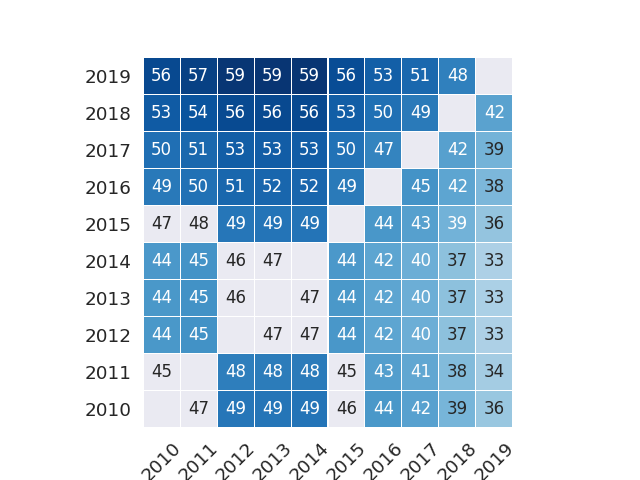

In [18]:
mw_pivot = mw_table.pivot('year_a', 'year_b', 'cles') * 100
mw_mask = mw_table.pivot('year_a', 'year_b', 'significance').astype("bool")

sns.set_context("paper", font_scale=1.5)
ax = sns.heatmap(
    mw_pivot,
    mask=~mw_mask,
    annot=True,
    fmt=".0f",
    vmin=20,
    vmax=60,
    cmap="Blues",
    cbar=False,
    square=True,
    annot_kws={'fontsize': 12}
)
sns.heatmap(
    mw_pivot,
    mask=mw_mask,
    ax=ax,
    annot=True,
    fmt=".0f",
    cmap=['#EAEAF2'],
    cbar=False,
    square=True,
    linewidths=0.05,
    annot_kws={'fontsize': 12}
)
ax.set_ylim(0, 10)  # I have no idea why it doesn't look right w/o this one...
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45)
#plt.yticks(rotation=45)

if True:
    plt.savefig('cles.pgf', bbox_inches='tight')


## Q2: Are older papers being forgotten?

We are trying to answer this question by answering the following:

+ **Are papers older than *N* years still being cited at the same rate now compared to then?**

<IPython.core.display.Javascript object>


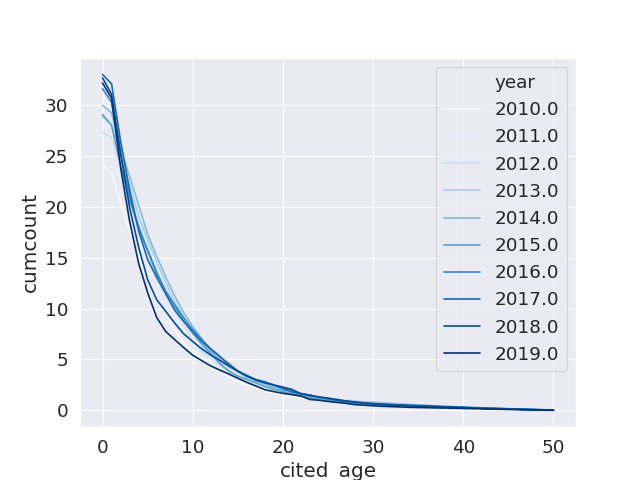

In [19]:
# normalize by total no. of *papers* in year
pfactor = df['paper_id'].groupby(df['year']).nunique('paper_id').reset_index()
counts['count'] = counts['count'].astype(float)
pcounts = counts.apply(lambda x: [x[0], x[1], x[2] / float(pfactor[pfactor['year']==x[0]]['paper_id']), x[3]], axis=1, result_type='broadcast')

# cumulative count of citations of age X or older
# need to reverse first so we start from the oldest...
pcounts = pcounts.sort_values(by='cited_age', ascending=False)
# then cumulatively sum up, for each year individually
pcounts['cumcount'] = pcounts.groupby('year')['count'].transform(pd.Series.cumsum)

sns.lineplot(data=pcounts, x='cited_age', y='cumcount', hue='year', legend='full', palette='Blues')

The graph above shows the **average number of citations per paper that are *X* or more years old**.

At point 0, it shows the average number of cited publications per paper. We can see that in more recent years, papers tend to cite more papers on average.  We can sanity-check that this calculation is correct by directly calculating the average number of citations per paper:

In [20]:
# no. of citations per paper
cpp = df.groupby(['paper_id', 'year']).count()['cited_age'].reset_index()
# mean by year
cpp.groupby('year').mean()

,cited_age
year,
2010,24.102612
2011,26.489540
2012,27.284387
2013,28.829960
2014,29.954802
2015,29.043084
2016,31.581146
2017,32.984865
2018,32.645897


Considering "older" citations, say, citations for papers that are at least 10 years old, the trend is that they are of course cited way less often, but **there doesn't appear to be a clear trend based on publication year**, giving evidence that they're not forgotten after all.

This can be seen more easily when zooming in on the older citations:

<IPython.core.display.Javascript object>


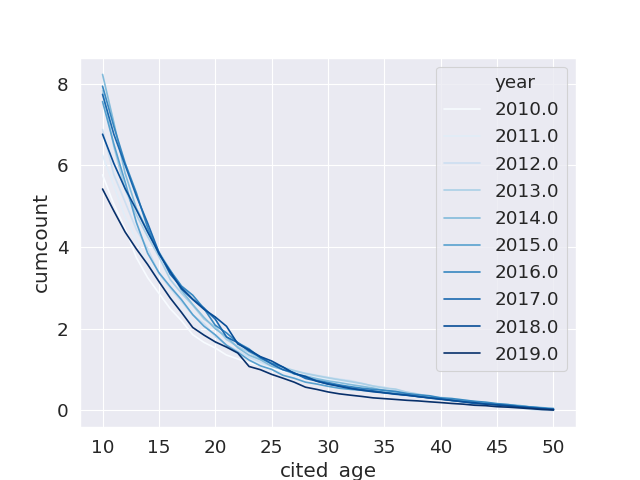

In [21]:
sns.lineplot(data=pcounts[pcounts['cited_age']>=10], x='cited_age', y='cumcount', hue='year', legend='full', palette='Blues')

In [22]:
AGG_MAX = 15

# aggregate citations >= AGG_MAX years old
aggdf = df.copy()
aggdf['cited_age'] = df['cited_age'].apply(lambda x: min(x, AGG_MAX))

# Count citations by year & cited_age
aggcounts = aggdf.groupby(['year', 'cited_age']).count()
aggcounts = aggcounts.reset_index().filter(items=['year', 'cited_age', 'venue'])
aggcounts.columns.values[-1] = "count"
aggcounts['count'] = aggcounts['count'].astype(float)

# normalize by total no. of *papers* in year
aggpcounts = aggcounts.apply(lambda x: [x[0], x[1], x[2] / float(pfactor[pfactor['year']==x[0]]['paper_id'])], axis=1, result_type='broadcast')

# cumulative count of citations of age X or older
# need to reverse first so we start from the oldest...
aggpcounts = aggpcounts.sort_values(by='cited_age', ascending=False)
# then cumulatively sum up, for each year individually
aggpcounts['cumcount'] = aggpcounts.groupby('year')['count'].transform(pd.Series.cumsum)

<IPython.core.display.Javascript object>


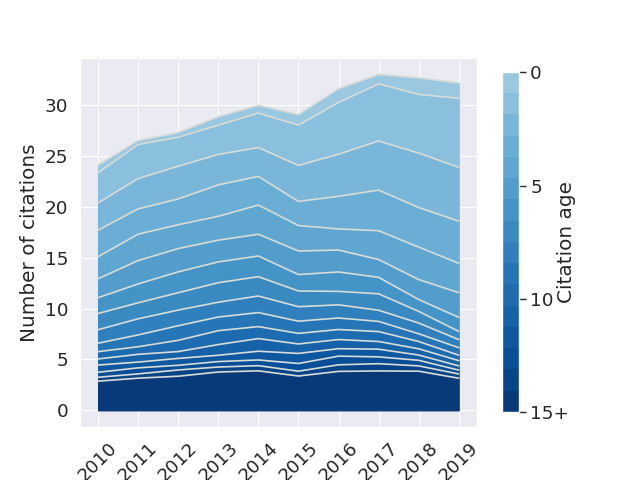

In [23]:
sns.set_context("paper", font_scale=1.5)
palette = sns.color_palette("Blues", n_colors=AGG_MAX+10)[-(AGG_MAX+1):]
linepal = [sns.xkcd_rgb["light grey"]] * (AGG_MAX+1)
#linepal = sns.color_palette("Blues", n_colors=AGG_MAX+10)[-(AGG_MAX+1+5):-5]
ax = sns.lineplot(data=aggpcounts, x='year', y='cumcount', hue='cited_age', legend=None, palette=linepal)

x = list(range(2010,2020))
aggpcounts = aggpcounts.sort_values(by='year', ascending=True)
for i in range(AGG_MAX):
    y1 = aggpcounts[aggpcounts['cited_age'] == i]['cumcount']
    y2 = aggpcounts[aggpcounts['cited_age'] == (i + 1)]['cumcount']
    plt.fill_between(x, y1, y2, color=palette[i])

y1 = aggpcounts[aggpcounts['cited_age'] == AGG_MAX]['cumcount']
y2 = [0] * len(y1)
plt.fill_between(x, y1, y2, color=palette[AGG_MAX])
#plt.colorbar()

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
cbar = plt.colorbar(
    ScalarMappable(
        cmap=ListedColormap(palette),
        norm=Normalize(vmin=0, vmax=AGG_MAX)
    ),
    ticks=[0, 5, 10, AGG_MAX],
    shrink=0.92
)
cbar.ax.invert_yaxis()
cbar.ax.set_yticklabels(["0","5","10","15+"])
cbar.set_label("Citation age", labelpad=-9)

ax.set_xlabel("")
ax.set_xticks(list(range(2010,2020)))
plt.xticks(rotation=45)
#ax.set_ylim(-1,34)
#ax.set_yticks(list(range(30,80,10)))
ax.set_ylabel("Number of citations")

if True:
    plt.savefig('iceberg.pgf', bbox_inches='tight')

### Oldest citation per paper

The following plot considers only the **distribution of the *oldest* citation per publication:**

<IPython.core.display.Javascript object>


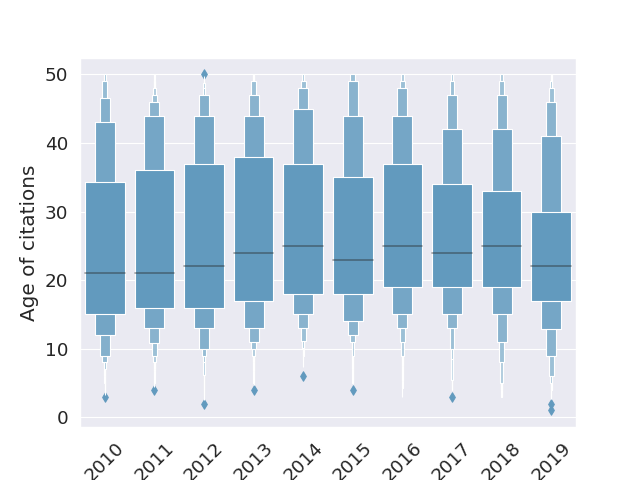

In [27]:
df_max = df.groupby(['paper_id', 'year'])["cited_age"].max().reset_index()
sns.set_context("paper", font_scale=1.5)
ax = sns.boxenplot(data=df_max, x='year', y='cited_age', palette=[sns.color_palette("Blues")[3]])

ax.set_xlabel("")
ax.set_ylabel("Age of citations")
plt.xticks(rotation=45)

if True:
    plt.savefig('oldest.pgf', bbox_inches='tight')

Which papers are the outliers at the bottom end of this plot?

In [28]:
df_max[df_max['cited_age'] <= 3]

,paper_id,year,cited_age
1349,D16-1203,2016,3
1396,D16-1250,2016,3
2025,D18-1298,2018,3
2067,D18-1341,2018,3
2223,D18-1503,2018,3
2638,D19-1382,2019,3
2850,D19-1599,2019,3
2858,D19-1607,2019,3
3470,J12-2012,2012,2
3709,N10-1037,2010,3


## Analysis by venue

<IPython.core.display.Javascript object>


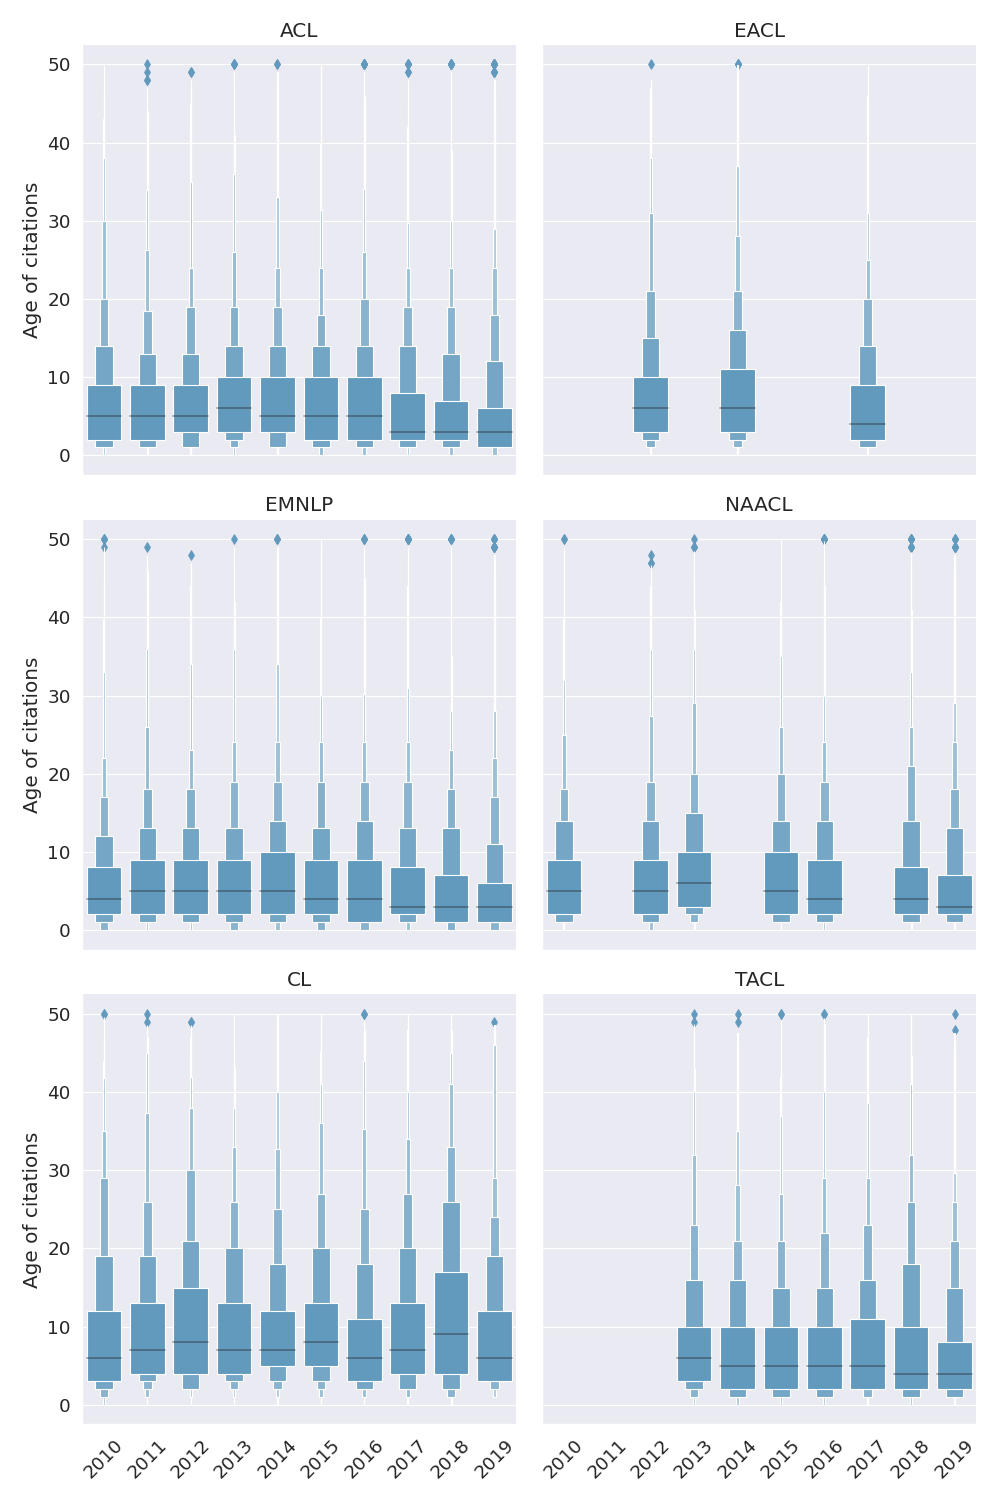

In [29]:
#sns.boxenplot(data=df[df['venue'] == 'CL'], x='year', y='cited_age')
#sns.lineplot(data=pcounts[pcounts['cited_age']>=10], x='cited_age', y='cumcount', hue='venue', legend='full', palette='Blues')
#df.columns

sns.set_context("paper", font_scale=1.5)
g = sns.FacetGrid(df, col='venue', 
                  col_order=["ACL","EACL","EMNLP","NAACL","CL","TACL"], col_wrap=2,
                  height=5)

g = (g.map(
        sns.boxenplot, 'year', 'cited_age',
        order=list(range(2010,2020)),
        palette=[sns.color_palette("Blues")[3]])
     .set_axis_labels("", "Age of citations")
     .set_titles("{col_name}")
     .set_xticklabels(list(range(2010,2020)), rotation=45)
    )

if True:
    plt.savefig('recency-by-venue.pgf', bbox_inches='tight')



Below is the average percentage of citations per paper that is **age 8 or higher**, per venue.

<IPython.core.display.Javascript object>


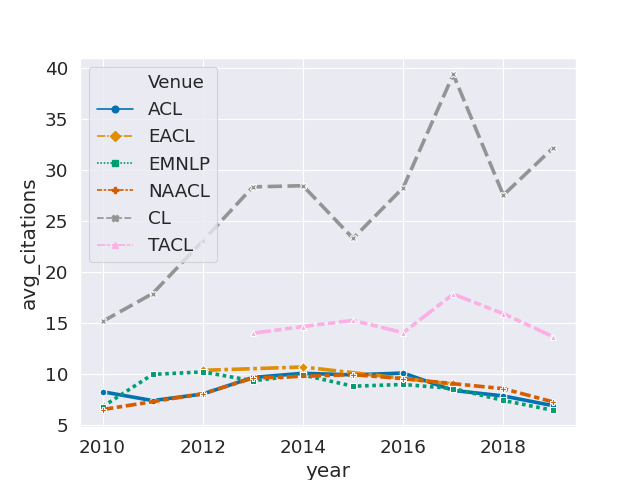

In [30]:
# Normalize by total no. of citations in year+venue
vfactor = df.groupby(['year', 'venue']).count()['cited_age']#.reset_index().index('venue')
vpfactor = df.groupby(['year', 'venue']).nunique('paper_id')['paper_id']#.reset_index()

def plot_vcounts(age, ycol='pct_citations'):
    # Count citations by year & cited_age
    vcounts = df[df['cited_age']>=age].groupby(['year', 'venue']).count()
    vcounts = vcounts.reset_index().filter(items=['year', 'venue', 'cited_age'])
    vcounts.columns.values[-1] = "count"

    vcounts['count'] = vcounts['count'].astype(float)
    vcounts['pct_citations'] = vcounts.apply(lambda x: 100 * x[2] / float(vfactor.loc[x[0]].loc[x[1]]), axis=1)
    vcounts['avg_citations'] = vcounts.apply(lambda x: x[2] / float(vpfactor.loc[x[0]].loc[x[1]]), axis=1)
    vcounts.columns.values[1] = "Venue"
    
    return sns.lineplot(
        data=vcounts,
        x='year',
        y=ycol,
        hue='Venue',
        hue_order=["ACL","EACL","EMNLP","NAACL","CL","TACL"],
        palette=VENUE_PALETTE,
        style='Venue',
        markers=True,
        legend='full',
        lw=2.6
    )

plot_vcounts(8, ycol='avg_citations')

It seems that CL publications cite considerably more older literature on average?

<IPython.core.display.Javascript object>


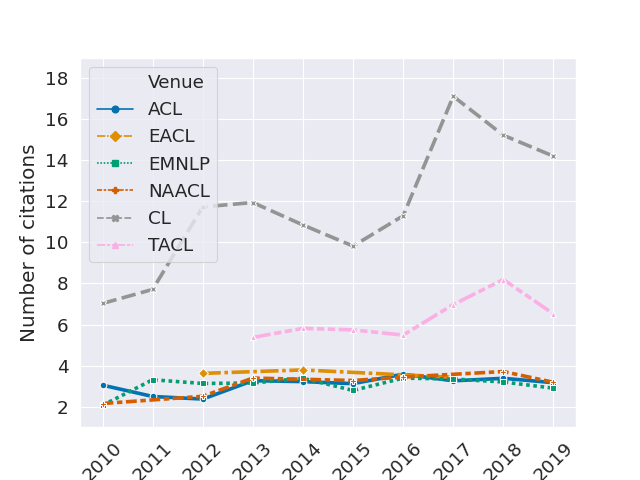

In [31]:
AGE = 15

sns.set_context("paper", font_scale=1.5)
ax = plot_vcounts(AGE, ycol='avg_citations')
ax.set_xlabel("")
ax.set_xticks(list(range(2010,2020)))
ax.set_ylim(1,19)
#ax.set_yticks(list(range(30,80,10)))
plt.xticks(rotation=45)
ax.set_ylabel(f"Number of citations")

#ax.get_legend().set_bbox_to_anchor((0.115, 0.0, 0.9, 0.88))

if True:
    plt.savefig('older15.pgf', bbox_inches='tight')


<IPython.core.display.Javascript object>


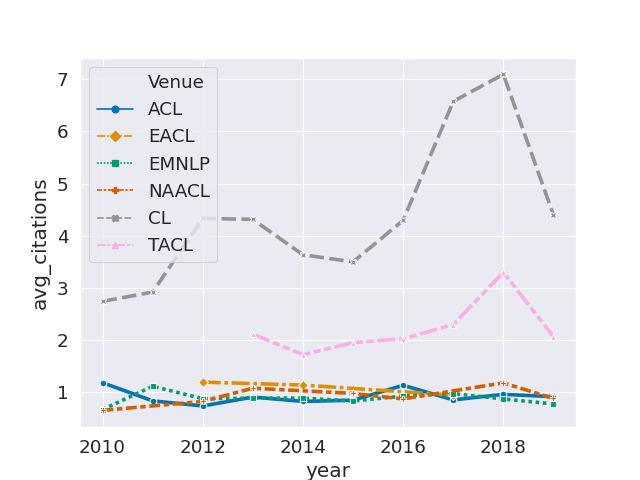

In [32]:
plot_vcounts(25, ycol='avg_citations')

<IPython.core.display.Javascript object>


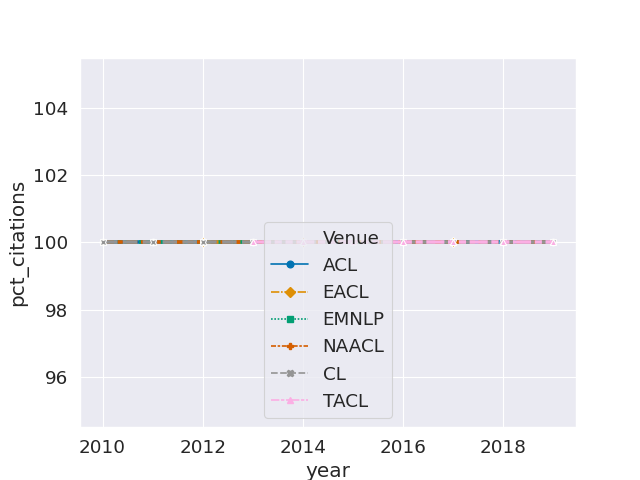

In [33]:
# sanity check :)
plot_vcounts(0)

<IPython.core.display.Javascript object>


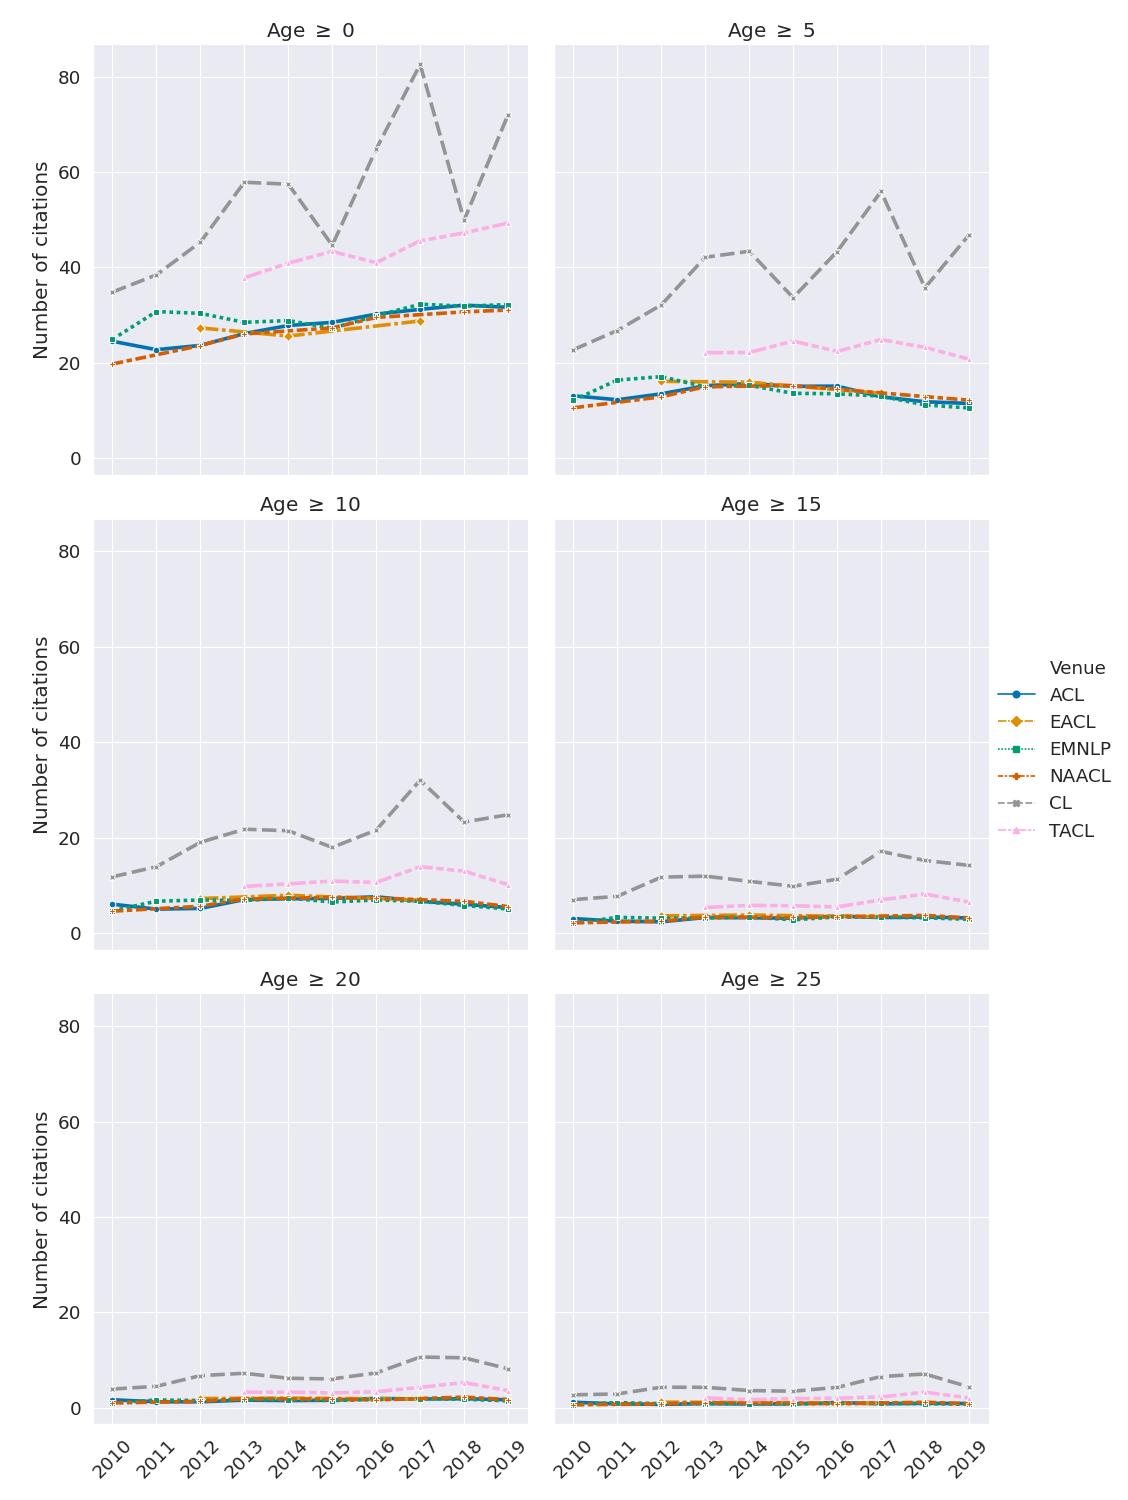

In [34]:
def get_vcounts_for_age(age):
    vcounts = df[df['cited_age']>=age].groupby(['year', 'venue']).count()
    vcounts = vcounts.reset_index().filter(items=['year', 'venue', 'cited_age'])
    vcounts.columns.values[-1] = "count"
    vcounts['count'] = vcounts['count'].astype(float)
    vcounts['pct_citations'] = vcounts.apply(lambda x: 100 * x[2] / float(vfactor.loc[x[0]].loc[x[1]]), axis=1)
    vcounts['avg_citations'] = vcounts.apply(lambda x: x[2] / float(vpfactor.loc[x[0]].loc[x[1]]), axis=1)
    vcounts.columns.values[1] = "Venue"
    vcounts['age'] = [age] * len(vcounts['count'])
    return vcounts

facets = [get_vcounts_for_age(age)
          for age in (0, 5, 10, 15, 20, 25)]
vcounts_df = pd.concat(facets)

sns.set_context("paper", font_scale=1.5)
g = sns.relplot(
    data=vcounts_df,
    x="year",
    y="avg_citations",
    col="age", col_wrap=2,
    hue="Venue",
    hue_order=["ACL","EACL","EMNLP","NAACL","CL","TACL"],
    palette=VENUE_PALETTE,
    style='Venue',
    markers=True,
    kind="line",
    lw=2.6,
    facet_kws={'sharey': True}
)

g = (g.set_axis_labels("", "Number of citations")
       .set_titles("Age $\geq$ {col_name}")
       .set(xticks=list(range(2010,2020)))
       .set_xticklabels(list(range(2010,2020)), rotation=45)
     )

if True:
    plt.savefig('older-facets.pgf', bbox_inches='tight')


## Distribution of number of citations vs. unique papers cited


In [35]:
with open("./data/citations-all.matched.tsv", "r", newline="") as csvfile:
    reader = csv.DictReader(csvfile, delimiter="\t")
    data = list(reader)

data = sorted(data, key=lambda x: int(x["num_cited"]), reverse=True)
for row in data:
    row["cited_in"] = Counter(int(f"20{id_[1:3]}") for id_ in row["citing_papers"].split(","))

In [36]:
# Only keep papers that have been cited somewhere in 2010
data2010 = [row for row in data if row["cited_in"][2010]]

# Only keep papers that were published in 1995 or earlier
data2010 = [row for row in data2010 if int(row["year"][:4]) < 1996]

print(f"This leaves us with {len(data2010)} papers.")

This leaves us with 1021 papers.


In [37]:
# Only keep papers that were published in 1995 or earlier
data_early = [row for row in data if int(row["year"][:4]) < 1996]

print(f"This leaves us with {len(data_early)} papers.")

This leaves us with 7038 papers.


In [38]:
def papers_in_year(year):
    return float(pfactor[pfactor['year']==year]['paper_id'])    

<IPython.core.display.Javascript object>


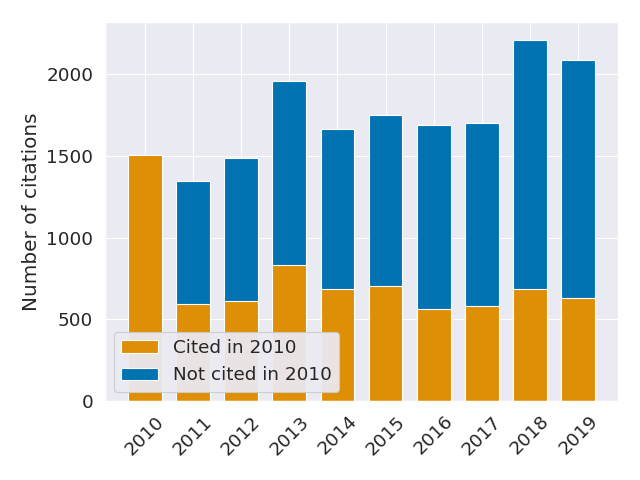

In [43]:
citedist = {
    y: [dp["cited_in"][y] for dp in data2010 if dp["cited_in"][y] > 0] for y in range(2010, 2020)
}
citedist_early = {
    y: [dp["cited_in"][y] for dp in data_early if dp["cited_in"][y] > 0] for y in range(2010, 2020)
}

sns.set_context("paper", font_scale=1.5)

a = plt.bar(list(range(10)),
            [sum(citedist_early[y]) for y in range(2010, 2020)],
            color=sns.color_palette("colorblind")[0],
            width=0.7)
b = plt.bar(list(range(10)),
            [sum(citedist[y]) for y in range(2010, 2020)],
            color=sns.color_palette("colorblind")[1],
            width=0.7)

g = plt.gca()
g.set_xticks(list(range(10)))
g.set_xticklabels(list(range(2010,2020)), rotation=45)
g.set_ylabel("Number of citations")
#g.set_ylim((0, 1200))

g.legend([b.patches[0], a.patches[0]], ["Cited in 2010", "Not cited in 2010"], loc="lower left", framealpha=.94)

# The same plot as above, but showing the total number of citations <=1995 in a given year.
plt.tight_layout()
if True:
    plt.savefig('cited-in-2010.pgf', bbox_inches='tight')

In [40]:
# What are these papers that are cited in 2019, but not yet in 2010?
data_x = [row for row in data if not row["cited_in"][2010] and int(row["year"]) <= (2019-15)]
for row in data_x:
    row["cited_in_2019"] = row["cited_in"][2019]
dfx = pd.DataFrame(data_x, columns=["id", "num_cited", "year", "authors", "title", "cited_in_2019"])
dfx.sort_values(by=["cited_in_2019"], ascending=False)[:10]

,id,num_cited,year,authors,title,cited_in_2019
0,1997-0151,382,1997,"S Hochreiter, J Schmidhuber",Long short-term memory.,91
1,1992-0102,173,1992,Ronald J Williams,Simple statistical gradient-following algorith...,83
2,1997-0126,122,1997,"Mike Schuster, Kuldip K Paliwal",Bidirectional recurrent neural networks.,40
10,1989-0070,32,1989,"Ronald J Williams, David Zipser",A learning algorithm for continually running f...,17
66,1990-0124,15,1990,"Charles T Hemphill, John J Godfrey, George R D...",The atis spoken language systems pilot corpus.,8
62,1966-0019,16,1966,Peter H Schonemann,A generalized solution of the orthogonal procr...,8
9,2004-0182,34,2004,"Fuchun Peng, Fangfang Feng, Andrew McCallum",Chinese segmentation and new word detection us...,7
5,1998-0210,45,1998,"Yann LeCun, Leon Bottou, Yoshua Bengio, Patric...",Gradient-based learning applied to document re...,7
112,1983-0033,12,1983,Karen Kukich,Design of a knowledge-based report generator.,7
40,1953-0007,19,1953,Wilson L Taylor,Cloze procedure: a new tool for measuring read...,7


<IPython.core.display.Javascript object>


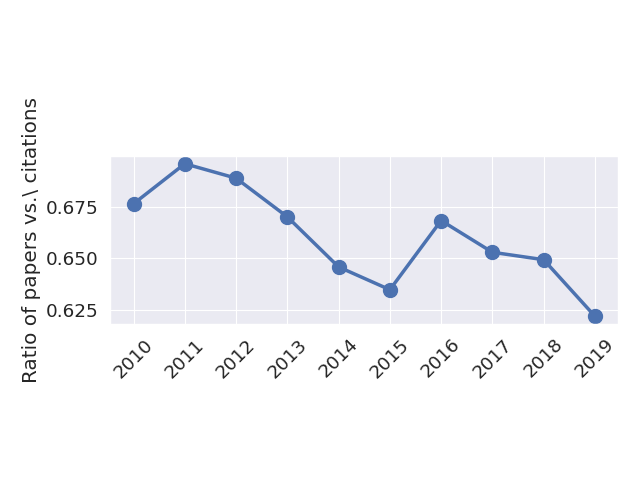

In [42]:
ratio = [len(citedist_early[y]) / sum(citedist_early[y]) for y in range(2010, 2020)]
plt.plot(list(range(10)), ratio, "o-", linewidth=2.5, markersize=10)

g = plt.gca()
g.set_xticks(list(range(10)))
g.set_xticklabels(list(range(2010,2020)), rotation=45)
g.set_ylabel("Ratio of papers vs.\ citations")
#g.set_ylim((0, 1200))
#g.set_yticks(list(range(5)))
g.set_aspect(40)

plt.tight_layout()
if True:
    plt.savefig('cite-paper-ratio.pgf', bbox_inches='tight')